In [1]:
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns

import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from gensim.models import FastText
from gensim.models import Word2Vec

In [2]:
seed = 1

In [4]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/artemsorokin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/artemsorokin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Data loading

In [3]:
raw_data = pd.read_csv('data/attributes.tsv', sep='\t')

### Data understanding

In [6]:
raw_data.head()

,Object_Id,Text_Value
0,1343152,"<p>Customer is an individual, group of individ..."
1,1343153,<p>Kind of person who is very likely to buy th...
2,1343154,<p>Customer who are loyal to us and repeat the...
3,1343155,<p>The customers who order the product or serv...
4,1343156,<p>Those who only buy or use the offering beca...


In [7]:
print(f'Number of rows in the dataset: {len(raw_data)}')
print('Number of unique objects:', len(raw_data['Object_Id'].unique()))

Number of rows in the dataset: 2369
Number of unique objects: 1726


Detailed examination of the data took place in excel.
- Many of the rows contained HTML markup.
- The texts varied in length from 2 characters to 6,000 characters.
- A large number of words are compound words. For example, "OrderQuantity".


### Data Preparation

In [8]:
def duplication_flag(df):
    """
    For duplicates we will set a flag to search 
    for patrons in objects consisting of several documents.
    """
    df['duplicated_object'] = df['Object_Id'].duplicated(keep=False)
    df = df.sort_values(by=['Object_Id'])

def object_grouping(df):
    """
    Grouping by objects, as some objects have several documents.
    """
    df['Text_Value'] = df.groupby('Object_Id')['Text_Value'].transform(lambda x: '; '.join(x.astype(str)))
    df.drop_duplicates(subset='Object_Id', inplace=True)
    df.reset_index(drop=True, inplace=True)

def html_removal(df):
    """
    Cleansing documents from HTML markup.
    """
    pattern = r'<[^>]+>|&nbsp;'
    df['Text_Value'] = df['Text_Value'].apply(lambda x: re.sub(pattern, '', x))

def punctuation_removal(df):
    """
    Punctuation cleanup.
    """
    pattern = r'[.,"\'-?:!;@]'
    df['Text_Value'] = df['Text_Value'].apply(lambda x: re.sub(pattern, '', x))

def lowercase(df):
    """
    We want to consider words written in
    different registers to be identical.
    For example, the words "apple" and "Apple".
    """
    df['Text_Value'] = df['Text_Value'].apply(lambda x: x.lower())

def new_features(df):
    """
    These variables are created for quicker and easier analysis 
    of the clustering performed. These variables do not participate
    in the clustering algorithm.
    """
    patterns = {
        'HR': r"\b\w*(?:hire|lastname|firstname|modelname|edu|person|human|gender|age\b|employee|resume|skills|job|salary|shift|occupation)\w*\b",
        'date_time': r"\b\w*(?:date|time|month|day|period|year|calendar|week)\w*\b",
        'business': r"\b\w*(?:business|product|customer|order|sales|performance|profit|gross|kpi\b)\w*\b",
        'finances': r"\b\w*(?:price|cost|tax|credit|accounting|currency|finance)\w*\b",
        'contact_data': r"\b\w*(?:phone|email)\w*\b",
        'location': r"\b\w*(?:address|city|geo|street|territory|postalcode|region)\w*\b",
        'DB_terms': r"\b\w*(?:primary|foreign|incremental|unique|id\b)"
        }
    
    for pattern_name, pattern in patterns.items():
        df[pattern_name] = df['Text_Value'].apply(lambda x: 1 if re.search(pattern, x, re.IGNORECASE) else 0)

def tokenization(df):
    """
    Splitting texts into word lists.
    Example: "Hi, how are you?" can be tokenized to the following tokens:
    ["Hi", ",", "how", "are", "you", "?"].
    """
    df['Text_Value'] = df['Text_Value'].apply(lambda x: word_tokenize(x))

def stop_words(df):
    """
    Exclude tokens that are frequently used words
    that do not greatly affect the meaning of the text.
    """
    stop_words = set(stopwords.words('english'))
    df['Text_Value'] = df['Text_Value'].apply(
        lambda x: [token for token in x if token not in stop_words])

def drop_empty_rows(df):
    """
    Deleting rows that have no text after cleaning.
    """
    df['len'] = df['Text_Value'].apply(len)
    indexes = df[df['len'] == 0].index
    df.drop(index=indexes, inplace=True)

def make_corpus(df):
    """
    Create a list of lists that will contain 
    all the texts available to us for training the model.
    """
    corpus = []
    corpus.extend(df['Text_Value'])

    return corpus

def index_reset(df):
    df.reset_index(drop=True, inplace=True)


def preprocess(df):
    """
    Preprocesses dataframe and returns
    preprocessed dataframe and the corpus to train the model.
    """
    df_preprocessed = df.copy()
    duplication_flag(df_preprocessed)
    object_grouping(df_preprocessed)
    html_removal(df_preprocessed)
    punctuation_removal(df_preprocessed)
    lowercase(df_preprocessed)
    new_features(df_preprocessed)
    tokenization(df_preprocessed)
    stop_words(df_preprocessed)
    drop_empty_rows(df_preprocessed)
    index_reset(df_preprocessed)
    corpus = make_corpus(df_preprocessed)

    return df_preprocessed, corpus

df_preprocessed, corpus = preprocess(raw_data)

### Vector representation

- Model training.
- Getting vector representation.
- Standardization or normalization.


In [9]:
def word2vec(df, corpus):
    """
    Creating a vector representation with Word2Vec.
    
    Since the texts are of different lengths
    we use the average value to represent the text
    as a vector in dimensionality 100.
    """
    model = Word2Vec(corpus, vector_size=100, window=5, min_count=1, workers=4, seed=seed)
    df['word_vectors'] = df['Text_Value'].apply(lambda x: [model.wv[token] for token in x])
    df['text_vector'] = df['word_vectors'].apply(lambda x: np.mean(x, axis=0))
    df.drop(columns='word_vectors', inplace=True)
    
def fasttext(df, corpus):
    """
    Creating a vector representation with FastText.
    
    Since the texts are of different lengths
    we use the average value to represent the text
    as a vector in dimensionality 100.
    """
    model = FastText(corpus, vector_size=100, window=5, min_count=1, workers=4, seed=seed)
    df['word_vectors'] = df['Text_Value'].apply(lambda x: [model.wv[token] for token in x])
    df['text_vector'] = df['word_vectors'].apply(lambda x: np.mean(x, axis=0))
    df.drop(columns='word_vectors', inplace=True)
    
def standardization(df):
    """
    Vector standardization.
    z = (x - u) / s
    """
    scaler = StandardScaler()
    dataset_raw = pd.DataFrame(df['text_vector'].to_list(),
                               columns=[f'atrr_{i}' for i in range(1,101)])

    dataset_standart = pd.DataFrame(scaler.fit_transform(dataset_raw),
                             columns = dataset_raw.columns)
    df.drop(columns=['text_vector'], inplace=True)

    return dataset_standart

def normalization(df):
    """
    Vector normalization.
    Bringing values into
    the interval from zero to one.
    """
    normalizer = Normalizer()
    dataset_raw = pd.DataFrame(df['text_vector'].to_list(),
                               columns=[f'atrr_{i}' for i in range(1,101)])

    dataset_norm = pd.DataFrame(normalizer.fit_transform(dataset_raw),
                             columns = dataset_raw.columns)
    df.drop(columns=['text_vector'], inplace=True)

    return dataset_norm

def vector_representation(df,
                          corpus,
                          standard=False,
                          normal=False):
    """
    The function calls 
    the functions described above and combines them.
    """
    if standard:
        word2vec(df, corpus)
        df_word2vec = standardization(df)
        fasttext(df, corpus)
        df_fasttext = standardization(df)
    elif normal:
        word2vec(df, corpus)
        df_word2vec = normalization(df)
        fasttext(df, corpus)
        df_fasttext = normalization(df)
    else:
        print('Choose standardization or normalization')

    return df_word2vec, df_fasttext

df_word2vec, df_fasttext = vector_representation(df_preprocessed, corpus, normal=True)

### Dimensionality reduction and visualization

- Reduction of dimensionality to 2 components.
- Used `t_SNE or PCA`. **The default is t_SNE**.
- Visualization of non-clustered texts.
- Visualization of clustered texts.



In [10]:
def dimensionalization(df,
                       after_clusterization=False,
                       t_SNE=True
):
    """
    Bringing vectors into two-dimensional space.
    t_SNE is default.
    If after_clusterization=True,
    it will create the third column of the dataset
    for further visualization of the cluster membership
    of certain objects.
    """
    if after_clusterization == False:
        if t_SNE == False:
            X_embedded = PCA(n_components=2, random_state=seed).fit_transform(df)
            df_vizual = pd.DataFrame(X_embedded, columns=['x', 'y'])
        if t_SNE:
            X = df.to_numpy()
            X_embedded = TSNE(n_components=2, random_state=seed).fit_transform(X)
            df_vizual = pd.DataFrame(X_embedded, columns=['x', 'y'])

    if after_clusterization:
        clusters = df['cluster'].to_list()
        df.drop(columns='cluster', inplace=True)
        if t_SNE == False:
            X_embedded = PCA(n_components=2, random_state=seed).fit_transform(df)
            df_vizual = pd.DataFrame(X_embedded, columns=['x', 'y'])
            df_vizual['cluster'] = clusters
        if t_SNE:
            X = df.to_numpy()
            X_embedded = TSNE(n_components=2, random_state=seed).fit_transform(X)
            df_vizual = pd.DataFrame(X_embedded, columns=['x', 'y'])
            df_vizual['cluster'] = clusters

    return df_vizual

def chart(df_vizual,
          after_clusterization=False
):
    """
    Creating a scatterplot.
    """
    width = 20
    height = 8
    sns.set(rc = {'figure.figsize':(width,height)})
    sns.set(font_scale=1.5)
    if after_clusterization:
        sns.scatterplot(df_vizual, x='x', y='y', hue='cluster', palette='Paired')
    else:
        sns.scatterplot(df_vizual, x='x', y='y')
    plt.legend().remove()
    plt.show()

def visualization(df,
                  after_clusterization=False,
                  t_SNE=True
):
    """
    Combining the functions described above.
    """
    if after_clusterization:
        if t_SNE == False:
            df_vizual = dimensionalization(df, after_clusterization=True, t_SNE=False)
            chart(df_vizual, after_clusterization=True)
        if t_SNE:
            df_vizual = dimensionalization(df, after_clusterization=True)
            chart(df_vizual, after_clusterization=True)
        
    else:
        if t_SNE == False:
            df_vizual = dimensionalization(df, t_SNE=False)
            chart(df_vizual)
        if t_SNE:
            df_vizual = dimensionalization(df)
            chart(df_vizual)

### Determination of the number of clusters for KNN

##### Support functions for determining the optimal number of clusters.
- **Elbow method** from the library Yellowbrick
- Cluster **silhouette coefficient**

In [11]:
def KElbow(df, n_clusters):
    model = KMeans(n_init='auto', random_state=seed)
    visualizer = KElbowVisualizer(model, k=(2, n_clusters), timings= True)
    visualizer.fit(df)
    visualizer.show()

def silhouette(df, n_clusters):
    k_clusters = []
    score = []

    for i in range(2, n_clusters):
        clusterer = KMeans(n_clusters=i, n_init='auto', random_state=seed)
        preds = clusterer.fit_predict(df)
        k_clusters.append(i)
        score.append(silhouette_score(df, preds))

    sns.lineplot(x=k_clusters, y=score)

    max_score = max(score)
    max_index = score.index(max_score)
    max_n_clusters = k_clusters[max_index]

    plt.axvline(x=max_n_clusters, color='r', linestyle='--')
    plt.plot(max_n_clusters, max_score, 'ro', label='Max Score')
    plt.legend()

    plt.xlabel('k')
    plt.ylabel('silhouette score')
    plt.title('Silhouette Score vs Number of Clusters')
    # plt.xticks(list(range(2, n_clusters+1)))

    plt.show()

    print(f"The highest score is {max_score} at n_clusters = {max_n_clusters}")

def knn_cluster_determination(df, n_clusters):
    KElbow(df, n_clusters)
    silhouette(df, n_clusters)

## Word2Vec
#### Determination of the number of clusters

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


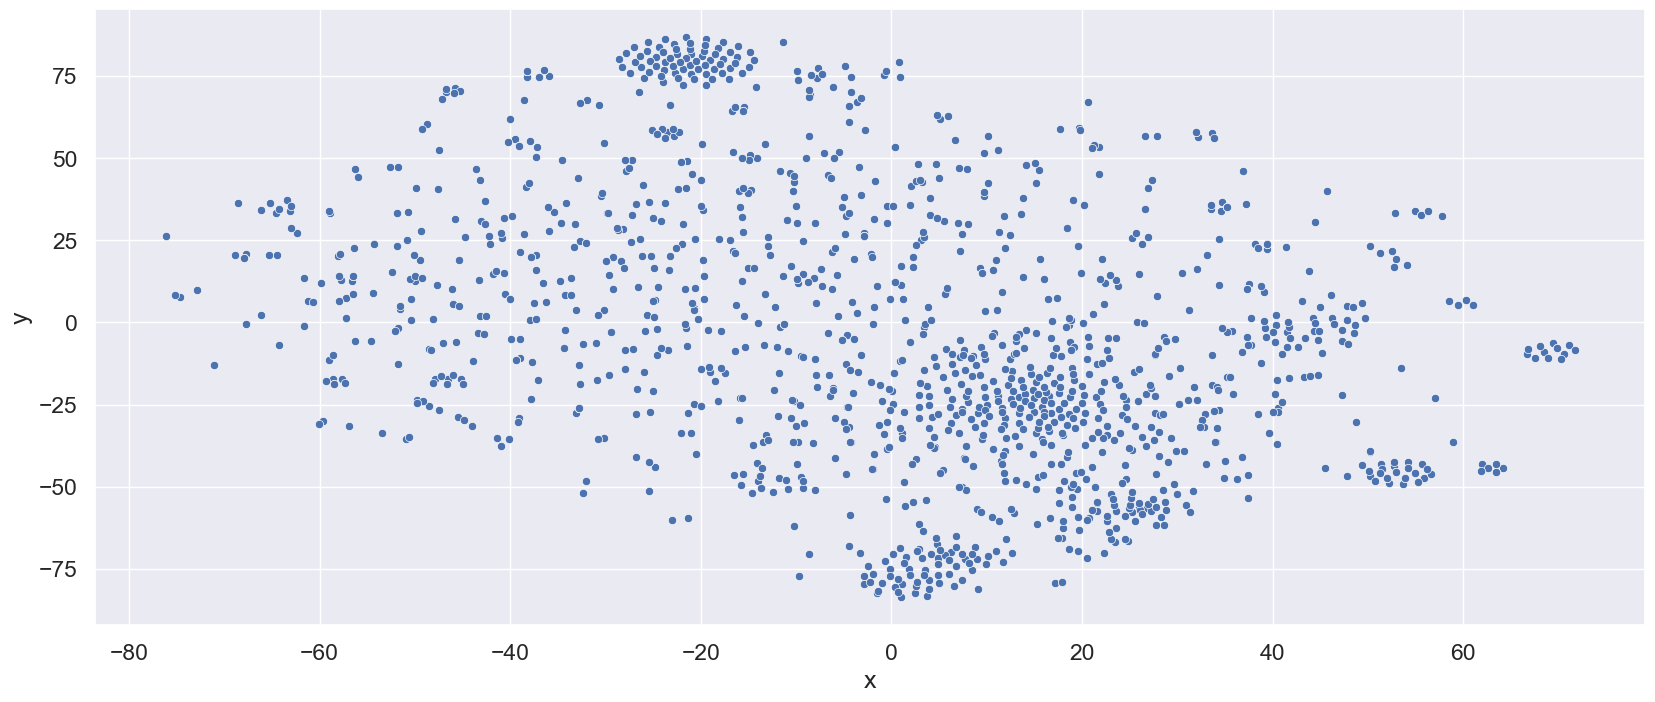

In [12]:
visualization(df_word2vec, t_SNE=True)

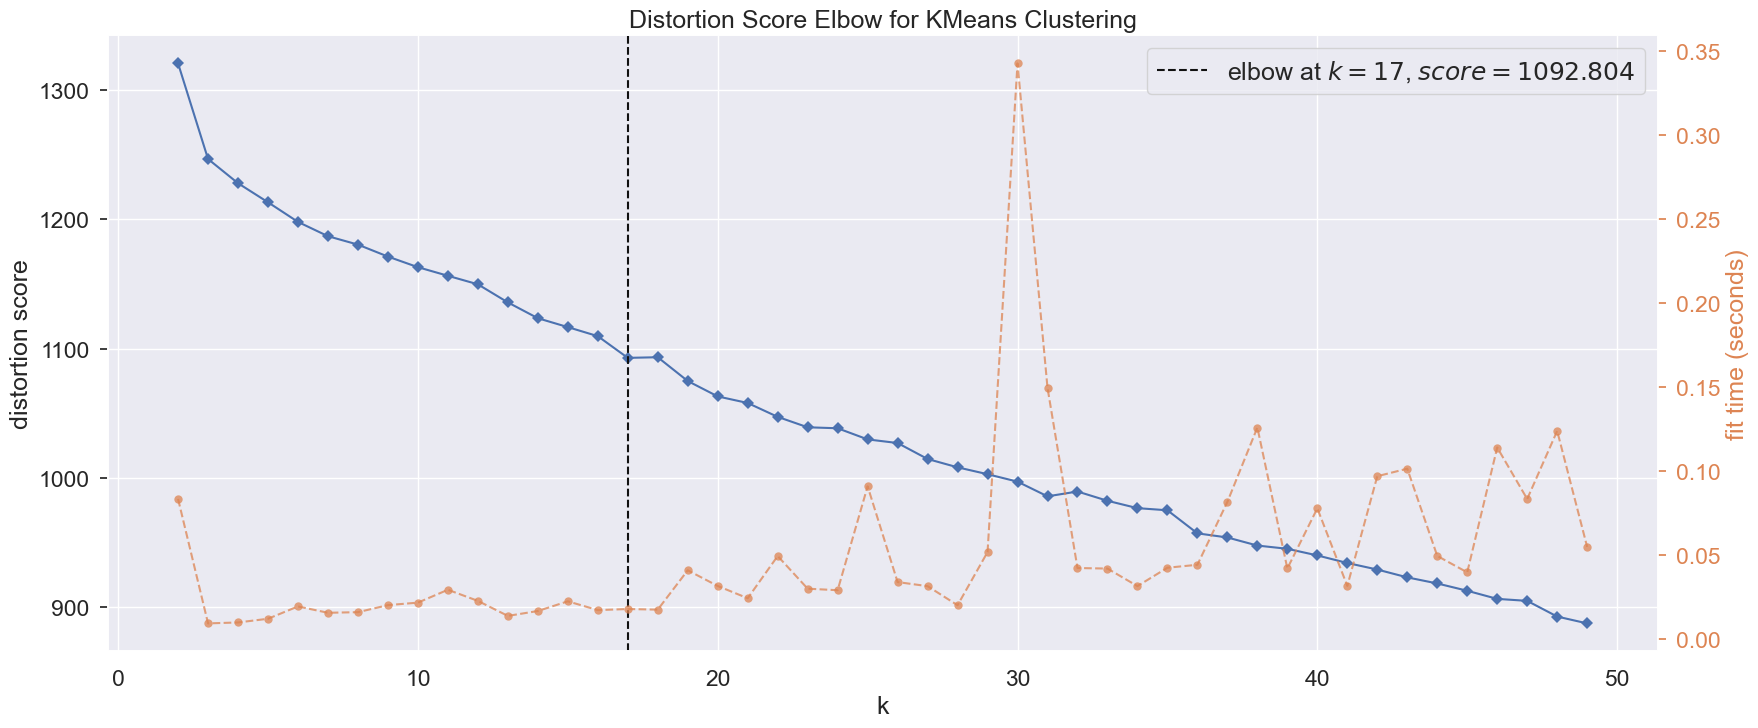

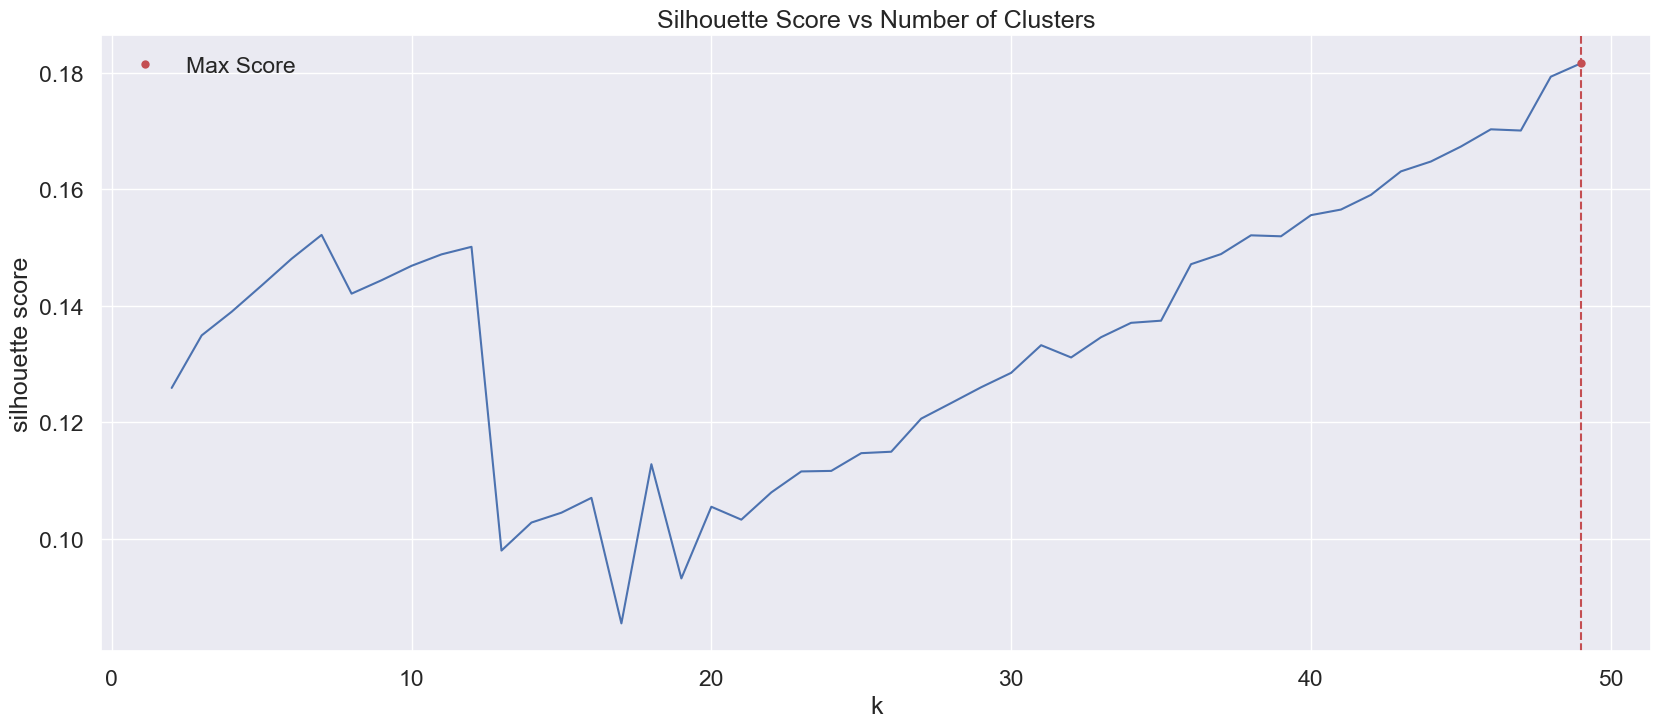

The highest score is 0.18160629272460938 at n_clusters = 49


In [13]:
knn_cluster_determination(df_word2vec, n_clusters=50)

Using Word2Vec, visualization in two-dimensional space reveals several distinct clusters. And a large discharged cloud of objects.

Using the elbow method does not lead to clear results. With the addition of each cluster, the distance decreases uniformly and there is no break in the graph.

## Fasttext
#### Determination of the number of clusters

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


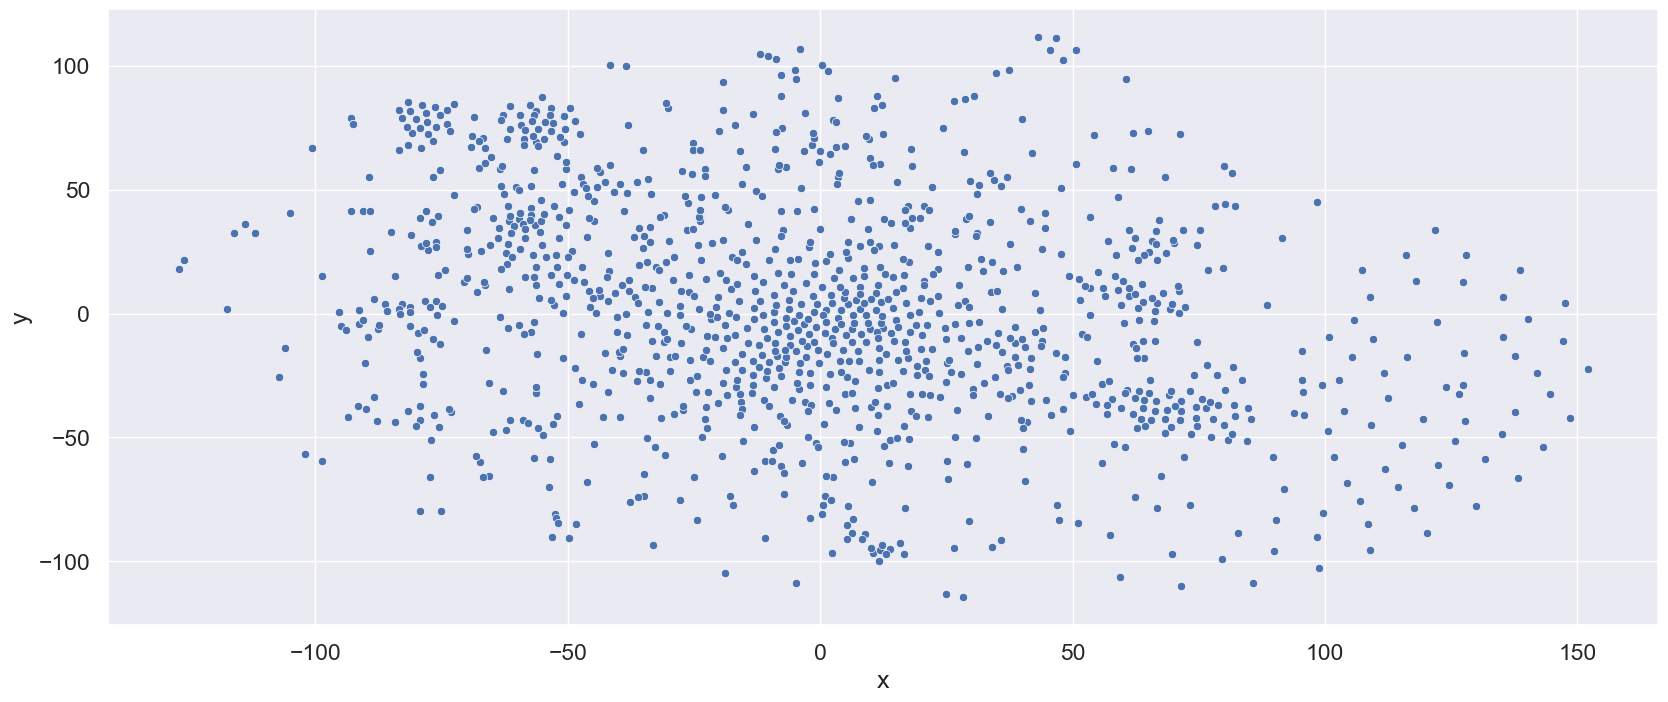

In [33]:
visualization(df_fasttext, t_SNE=True)

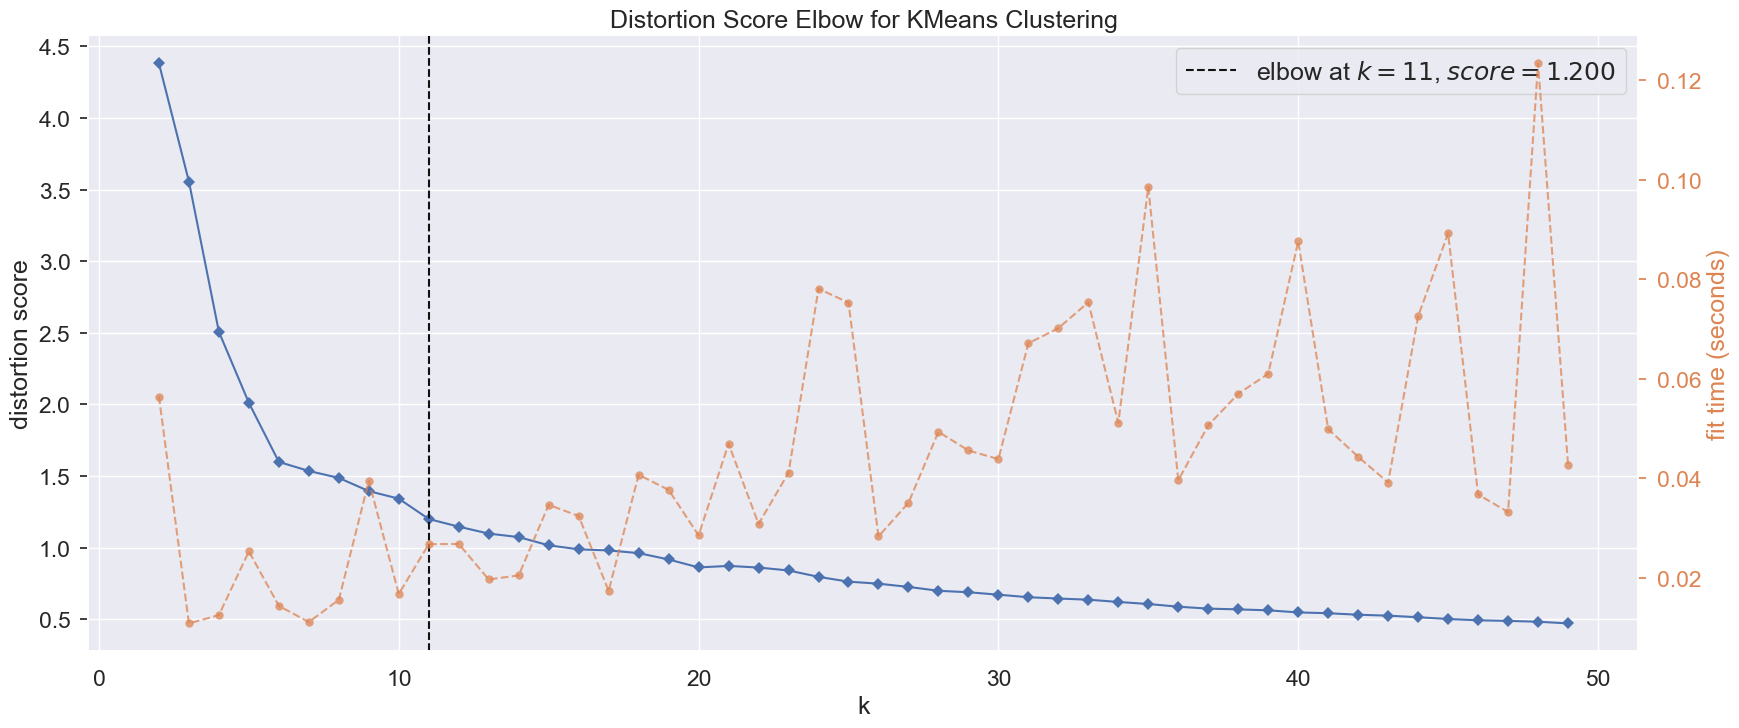

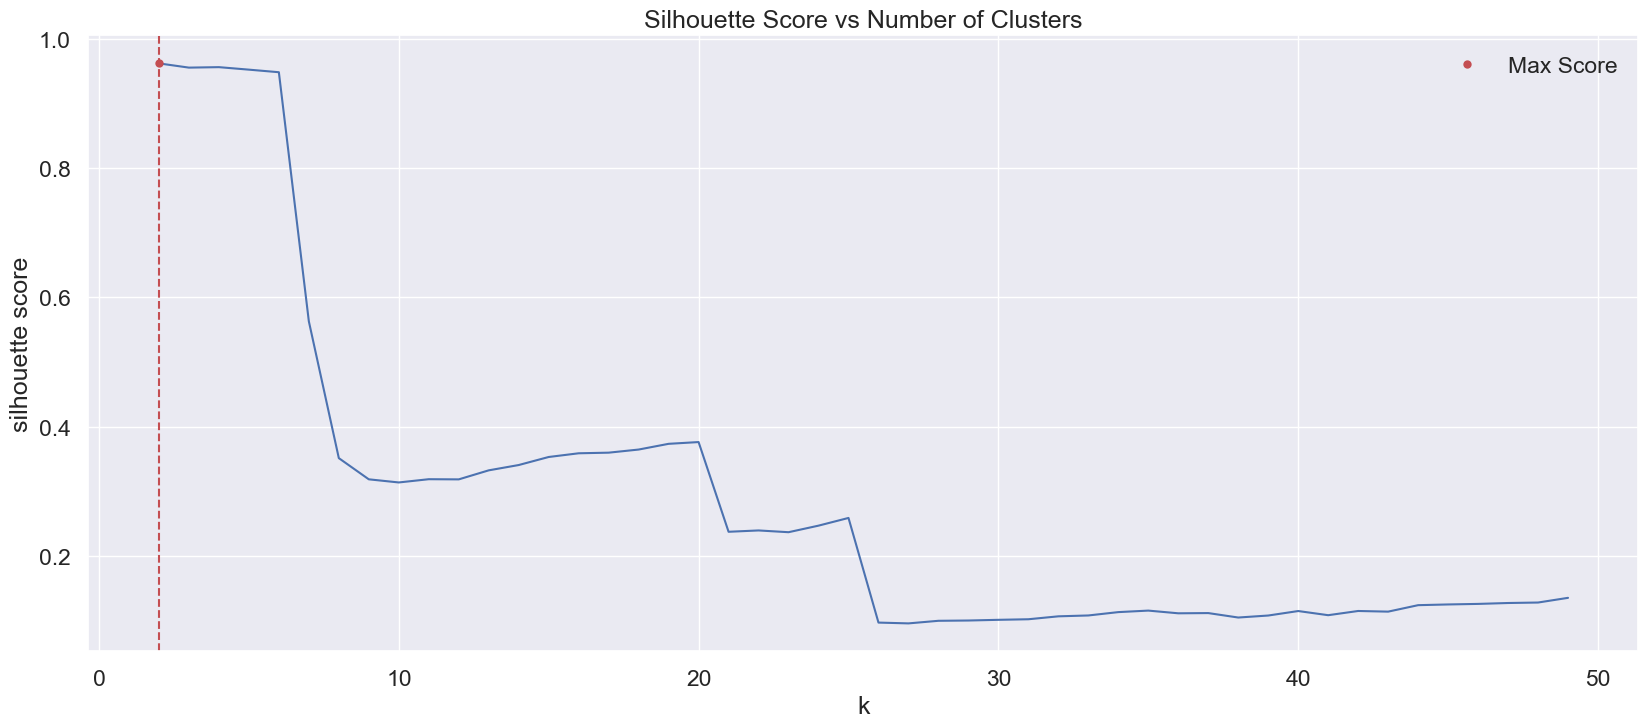

The highest score is 0.9619833827018738 at n_clusters = 2


In [34]:
knn_cluster_determination(df_fasttext, n_clusters=50)

When using FastText, certain groups of clusters are also visible. But in general, this visualization makes me think that the distribution is not quite correct.

The elbow method has an obvious line break in the 6th cluster, but the silhouette coefficient has the highest value at the most initial point (2 clusters), which also makes me think that this approach works incorrectly.

### Clusterization
- A certain number of clusters based on the previous steps.
- Visualization of color-coded clusters in two-dimensional space.
- Option to save the file in Excel format.

I use two algorithms for clustering. 
1) *KNN*
2) *Hierarchical cluster analysis* `(linkage='ward', metric='euclidean')`

In the final iteration, I chose a vector space obtained using **Word2Vec and 30 clusters.**   
As it was seen from the graph of elbow method and silhouette coefﬁcient, each additional cluster brought a positive result. 
30 clusters were enough to identify the main groups of object clusters. 

In [16]:
def clusterization_knn(df,
                       k,
                       t_SNE=True,
                       save=False,
                       name=False):
    """
    KNN method.
    (t_SNE) by default.
    If (save=True), the clustering results
    will be saved to an Excel file
    with a specific name in the (name) parameter.
    """
    model = KMeans(n_clusters=k, n_init='auto', random_state=seed)
    model.fit(df)
    df['cluster'] = model.labels_
    if t_SNE:
        visualization(df, after_clusterization=True)
    if t_SNE == False:
        visualization(df, after_clusterization=True, t_SNE=False)

    if save:
        df_preprocessed['cluster'] = model.labels_
        if name == False:
            print('add file name')
        else:
            df_preprocessed.to_excel(f'{name}.xlsx')


def hierarchical_clusterization(df,
                                k,
                                t_SNE=True,
                                save=False,
                                name=False):
    """
    Hierarchical cluster analysis.
    (t_SNE) by default.
    If (save=True), the clustering results
    will be saved to an Excel file
    with a specific name in the (name) parameter.
    """
    model = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='ward')
    model.fit_predict(df)
    df['cluster'] = model.labels_
    if t_SNE:
        visualization(df, after_clusterization=True)
    if t_SNE == False:
        visualization(df, after_clusterization=True, t_SNE=False)

    if save:
        df_preprocessed['cluster'] = model.labels_
        if name == False:
            print('add file name')
        else:
            df_preprocessed.to_excel(f'{name}.xlsx')


#### KNN

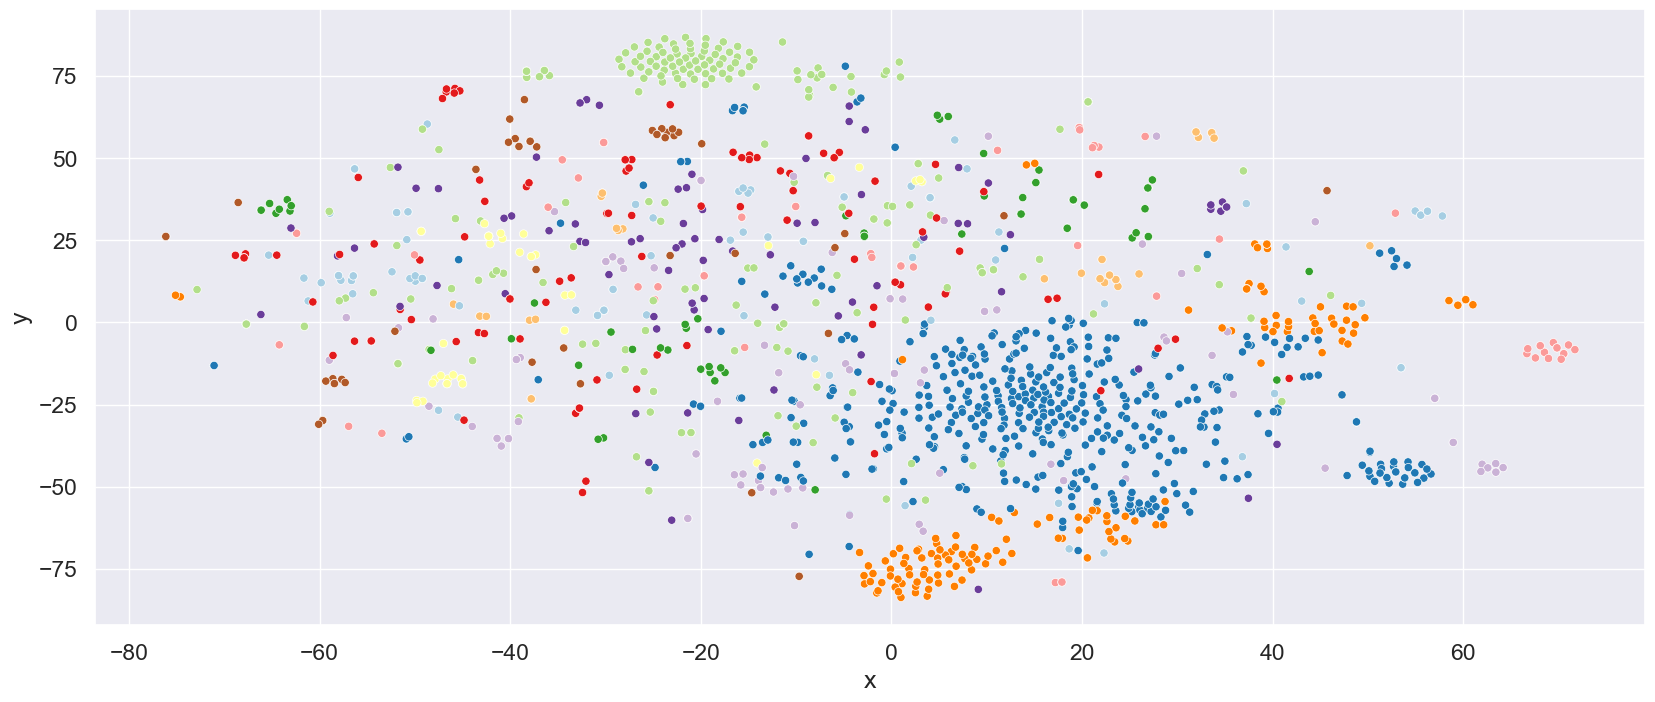

In [17]:
clusterization_knn(df_word2vec, k=30)

#### Hierarchical Сlustering

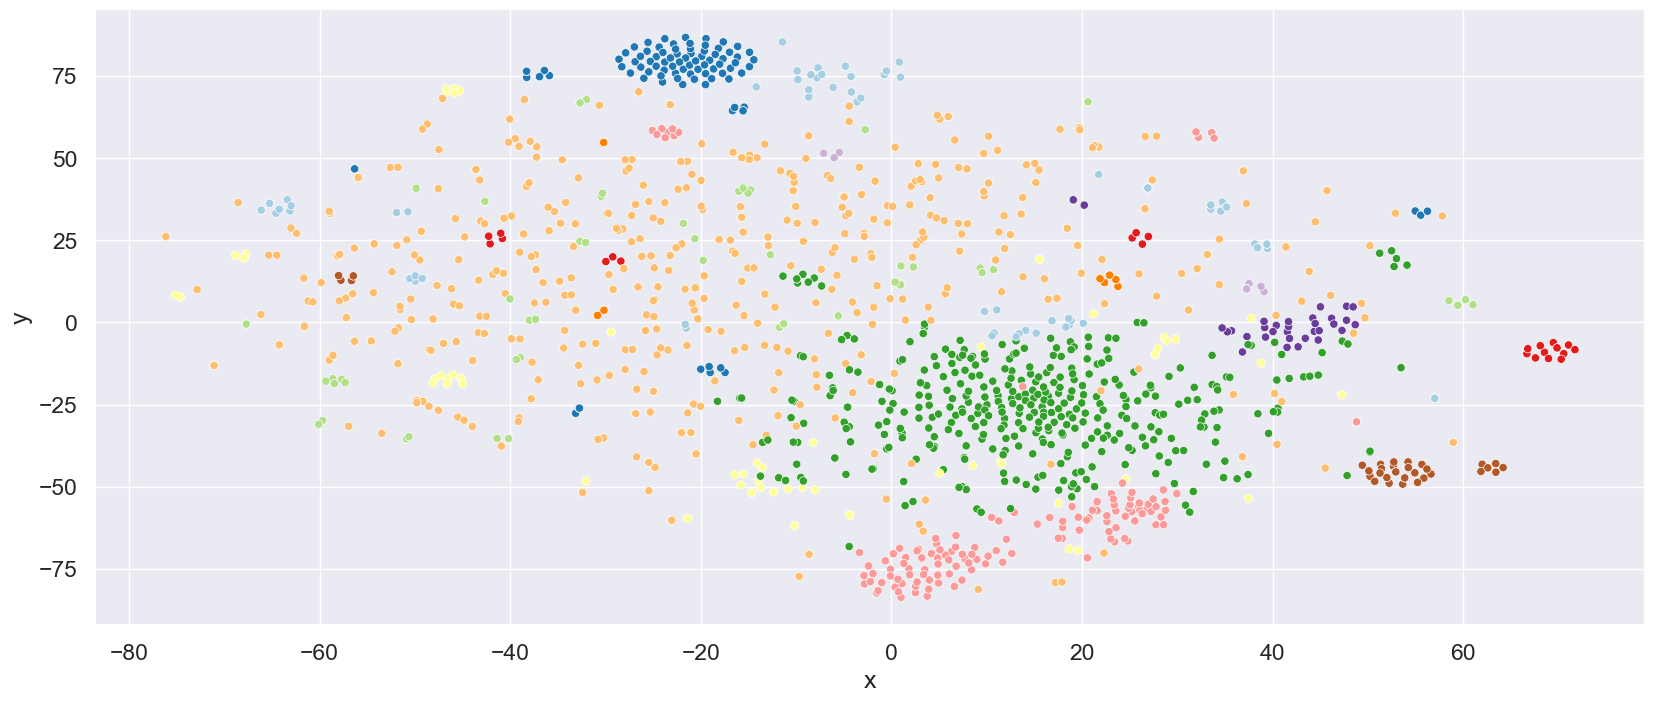

In [35]:
hierarchical_clusterization(df_word2vec, k=30)

Clustering without using a model trained on a large corpus *did not bring satisfactory clustering*.

In addition to using vector representation from FastText and Word2Vec, I also tried an approach using *additional attributes* `HR, date_time, business, finances, contact_data, location, DB_terms` based on manually defined patterns. 

This option showed good clustering results, but I gave up this approach due to its lack of flexibility and semi-automation.

However, the combination of Word2Vec, KNN and 30 clusters gave the best object distribution results.

---

## Pre-trained model

This approach uses a pre-trained language model **sentence-transformers/paraphrase-MiniLM-L3-v2**.

Sentence-transformers/paraphrase-MiniLM-L3-v2 is a model developed for the task of sentence paraphrasing. It is based on the MiniLM architecture, which is compact and efficient for text processing.
MiniLM is a scaled-down version of the Transformer-based language model (LM).

- Max Sequence Length: 128
- Dimensions: 384
- Normalized Embeddings: false
- Size: 61 MB

In this work the model used to obtain _Embeddings_ of texts.

In [4]:
from sentence_transformers import SentenceTransformer

/Users/artemsorokin/miniforge3/envs/ud4d/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Preparation

There is no need to prepare word tokens to use the model. The model can digest texts in their original form.  
Therefore, the text preparation step is characterized by the absence of some preprocessing steps.

In [5]:
def object_grouping(df):
    """
    Grouping by objects,
    as some objects have several documents.
    """
    df['Text_Value'] = df.groupby('Object_Id')['Text_Value'].transform(lambda x: '; '.join(x.astype(str)))
    df.drop_duplicates(subset='Object_Id', inplace=True)
    df.reset_index(drop=True, inplace=True)

def html_removal(df):
    """
    Cleansing documents from HTML markup
    """
    pattern = r'<[^>]+>|&nbsp;'
    df['Text_Value'] = df['Text_Value'].apply(lambda x: re.sub(pattern, '', x))

def remove_empty_row(df):
    """
    Deleting rows that have no text after cleaning.
    """
    df['len'] = df['Text_Value'].apply(lambda x: len(x))
    indexes = df[df['len'] == 0].index
    df.drop(index=indexes, inplace=True)

def new_features(df):
    """
    These variables are created for quicker and easier analysis 
    of the clustering performed. These variables do not participate
    in the clustering algorithm.
    """
    patterns = {
        'HR': r"\b\w*(?:hire|lastname|firstname|modelname|edu|person|human|gender|age\b|employee|resume|skills|job|salary|shift|occupation)\w*\b",
        'date_time': r"\b\w*(?:date|time|month|day|period|year|calendar|week)\w*\b",
        'business': r"\b\w*(?:business|product|customer|order|sales|performance|profit|gross|kpi\b)\w*\b",
        'finances': r"\b\w*(?:price|cost|tax|credit|accounting|currency|finance)\w*\b",
        'contact_data': r"\b\w*(?:phone|email)\w*\b",
        'location': r"\b\w*(?:address|city|geo|street|territory|postalcode|region)\w*\b",
        'DB_terms': r"\b\w*(?:primary|foreign|incremental|unique|id\b)"
        }
    
    for pattern_name, pattern in patterns.items():
        df[pattern_name] = df['Text_Value'].apply(lambda x: 1 if re.search(pattern, x, re.IGNORECASE) else 0)

def index_reset(df):
    df.reset_index(drop=True, inplace=True)

def preparation(df):
    """
    Pre-processes the data and
    returns a preprocessed dataset for further clustering.
    """
    prepared_df = df.copy()
    object_grouping(prepared_df)
    html_removal(prepared_df)
    remove_empty_row(prepared_df)
    new_features(prepared_df)
    index_reset(prepared_df)

    return prepared_df

prepared_df = preparation(raw_data)

### Vector representation

In [7]:
def embeddings(df):
    """
    Obtaining Embedding.
    """
    corpus = df['Text_Value'].to_list()
    model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L3-v2', )
    embeddings = model.encode(corpus)
    df['embeddings'] = embeddings.tolist()

def standardization(df):
    """
    Vector standardization.
    z = (x - u) / s
    """
    scaler = StandardScaler()
    dataset_raw = pd.DataFrame(df['embeddings'].to_list(),
                               columns=[f'atrr_{i}' for i in range(1,385)])

    dataset_standart = pd.DataFrame(scaler.fit_transform(dataset_raw),
                             columns = dataset_raw.columns)
    return dataset_standart

def normalization(df):
    """
    Vector normalization.
    Bringing values into
    the interval from zero to one.
    """
    normalizer = Normalizer()
    dataset_raw = pd.DataFrame(df['embeddings'].to_list(),
                               columns=[f'atrr_{i}' for i in range(1,385)])

    dataset_norm = pd.DataFrame(normalizer.fit_transform(dataset_raw),
                             columns = dataset_raw.columns)
    return dataset_norm

def SentenceTransformers(df,
                         standard=False,
                         normal=False
):
    """
    The function calls 
    the functions described above and combines them.
    """
    embeddings(df)
    if standard:
        sentence_transformers_df = standardization(df)
    elif normal:
        sentence_transformers_df = normalization(df)
    else:
        print('Choose standardization or normalization')
    
    return sentence_transformers_df

sentence_transformers_df = SentenceTransformers(prepared_df, normal=True)

### Clusterization

In [8]:
def hierarchical_clusterization_transformer(df,
                                            k,
                                            t_SNE=True,
                                            save=False,
                                            name=False):
    """
    Hierarchical cluster analysis.
    (t_SNE) by default.
    If (save=True), the clustering results
    will be saved to an Excel file
    with a specific name in the (name) parameter.
    """
    model = AgglomerativeClustering(n_clusters=k,
                                    metric='euclidean',
                                    linkage='ward')
    model.fit_predict(df)
    df['cluster'] = model.labels_
    if t_SNE:
        visualization(df, after_clusterization=True)
    if t_SNE == False:
        visualization(df, after_clusterization=True, t_SNE=False)

    if save:
        prepared_df['cluster'] = model.labels_
        if name == False:
            print('add file name')
        else:
            prepared_df.to_excel(f'{name}.xlsx')


def clusterization_knn_transformer(df,
                                   k,
                                   t_SNE=True,
                                   save=False,
                                   name=False):
    """
    KNN method.
    (t_SNE) by default.
    If (save=True), the clustering results
    will be saved to an Excel file
    with a specific name in the (name) parameter.
    """
    model = KMeans(n_clusters=k, n_init='auto', random_state=seed)
    model.fit(df)
    df['cluster'] = model.labels_
    if t_SNE:
        visualization(df, after_clusterization=True)
    if t_SNE == False:
        visualization(df, after_clusterization=True, t_SNE=False)

    if save:
        prepared_df['cluster'] = model.labels_
        if name == False:
            print('add file name')
        else:
            prepared_df.to_excel(f'{name}.xlsx')

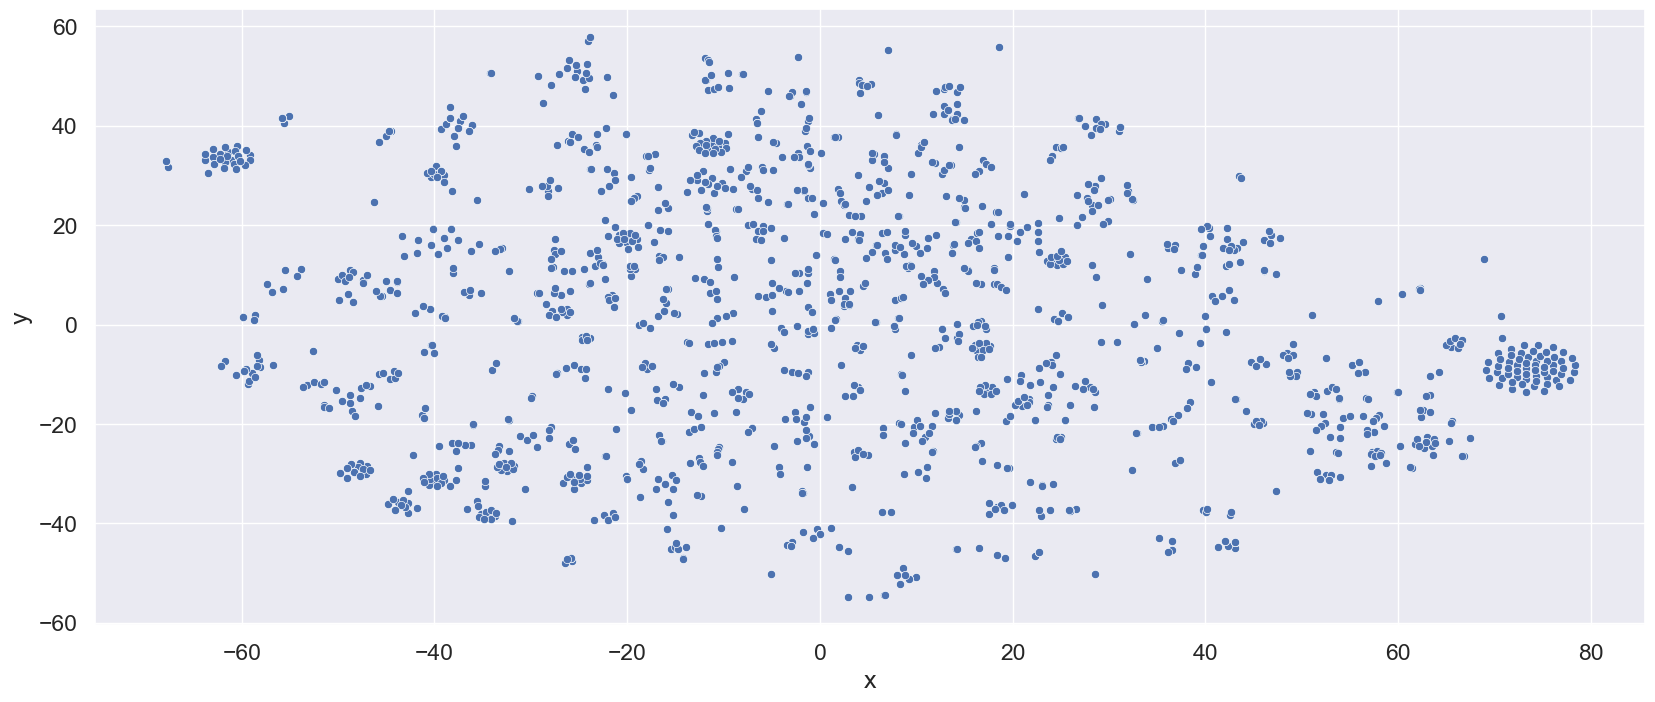

In [97]:
visualization(sentence_transformers_df, t_SNE=True)

Visualization in two-dimensional space showed excellent results. Several large clusters and many medium and small clusters are visible.

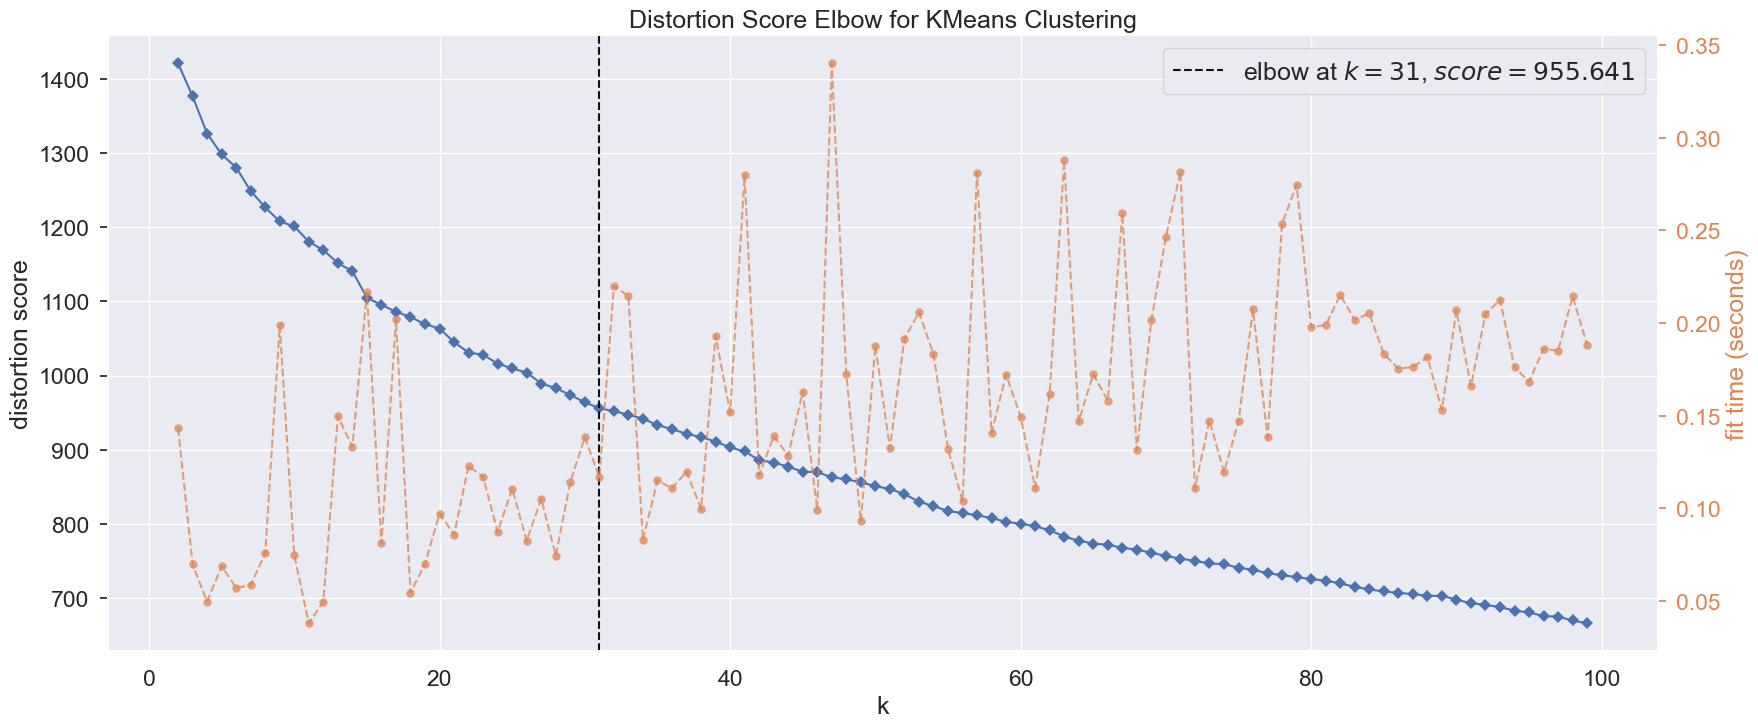

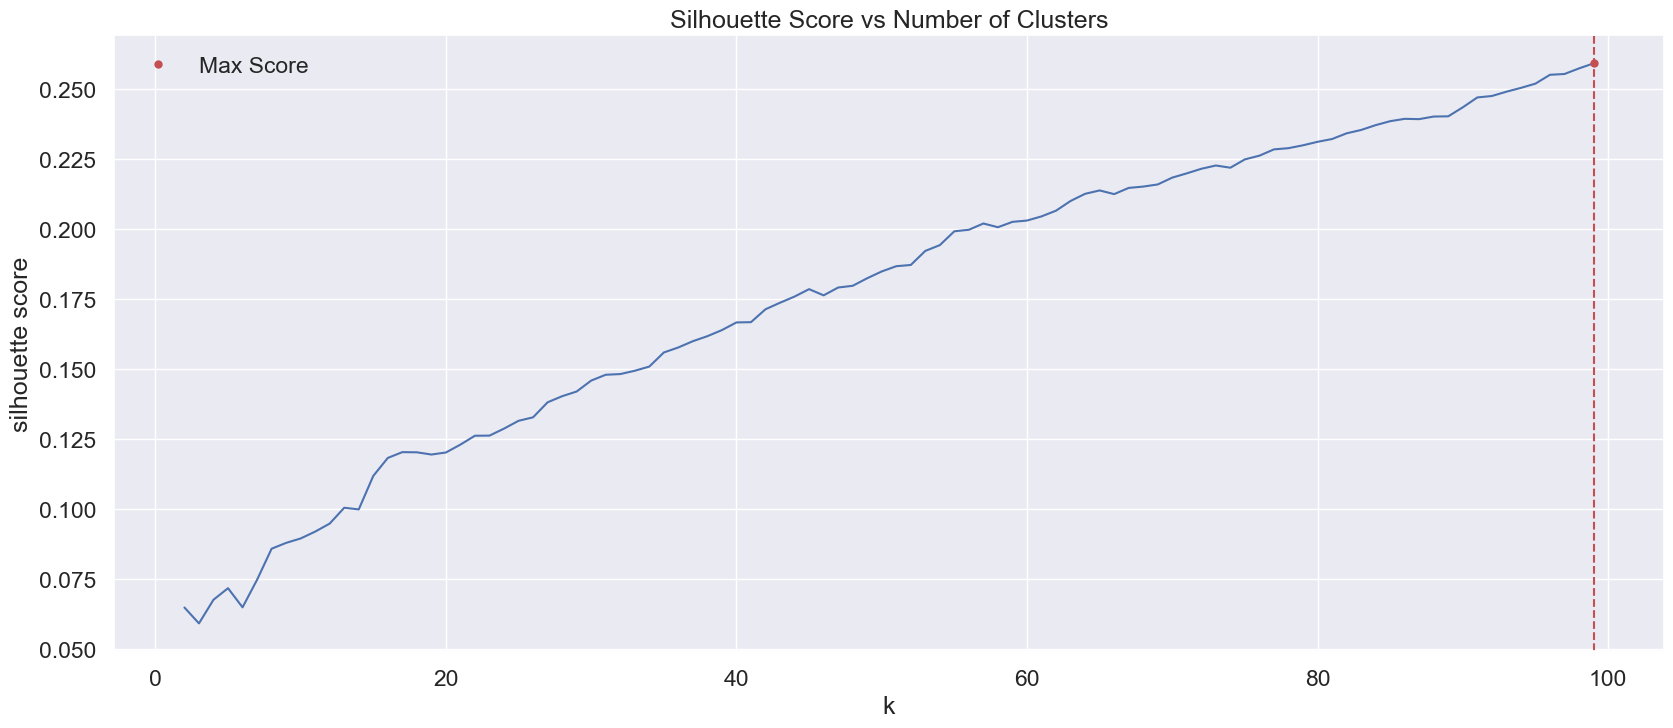

The highest score is 0.25926219044128457 at n_clusters = 99


In [103]:
knn_cluster_determination(sentence_transformers_df, n_clusters=100)

The elbow method and the silhouette coefficient do not indicate a certain number of clusters. Each further separation brings relatively equal reduction of distance between clusters and the silhouette coefficient grows relatively constant.

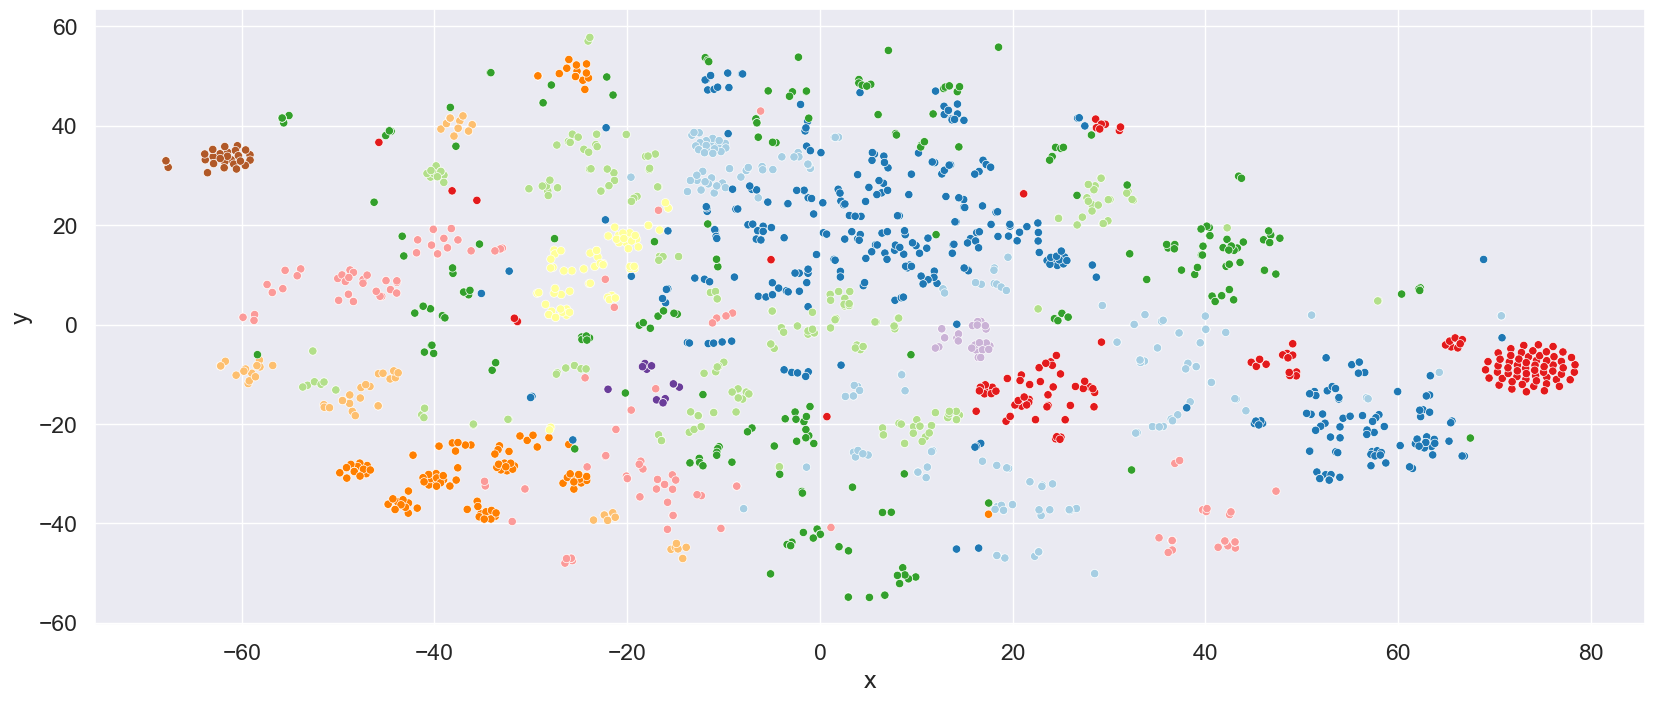

In [127]:
hierarchical_clusterization_transformer(sentence_transformers_df, k=20)

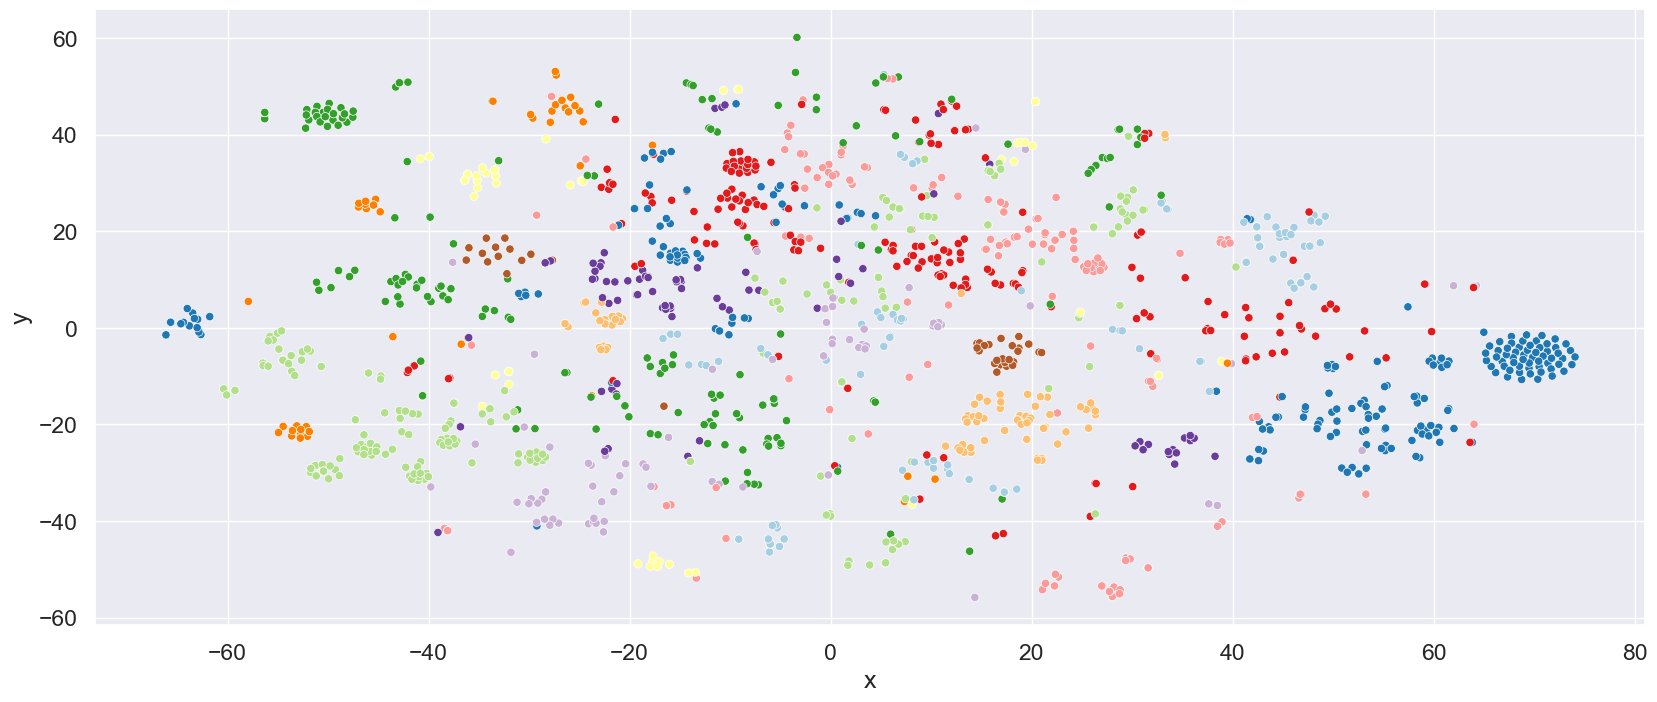

In [11]:
clusterization_knn_transformer(sentence_transformers_df, k=30)

Above are visualizations using hierarchical clustering and KNN. It is difficult to emphasize certain differences from the graphs. But when analyzing the results of clustering **KNN showed excellent results** in terms of logical filling of clusters.